## <font color = "#CC3D3D">Case #1: Binarization</font>

<hr>

### Step #1: Binarization of image
<hr>

- 영상의 이진화
    - 영상의 픽셀 각 픽셀 값을 두 개의 부류(0 또는 255(1))로 나누는 작업이다.
        - 배경 vs 객체
        - 관심 영역 vs 비관심 영역
        - <img src="images/markdown/binarization_of_image.png" width="500">
        - 이진화된 영상은 픽셀당 1비트(bit)를 이용하여 정보를 표현할 수 있지만,<br>
        여러 응용에서 그레이스케일 영상이 널리 사용되고 있기 때문에 이진 영상도<br>
        보통 CV_8UC1 타입 영상으로 표현한다.

<hr>

- 그레이스케일 영상의 이진화

$$g(x,y)=\begin{cases}
&0&\text{if}\ f(x,y)\le T\\
&255&\text{if}\ f(x,y)>T
\end{cases}
\quad\cdot T:\ \scriptstyle{\text{임계값, 문턱치}},\ \text{threshold}$$

<img src="images/markdown/binarization_of_grayscale.png" width="600">

<hr>

### Step #2: OpenCV function
<hr>

> `임계값 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}threshold}(src, thresh, maxval, type, dst)\rightarrow retval,\ dst}$$
- src: source. 입력 영상. 다채널, 8비트 또는 32비트 실수형
- thresh: 사용자 지정 임계값
- maxval: max value. cv2.THRESH_BINARY or cv2.THRESH_BINARY_INV 방법 사용 시 최댓 값
- type: ThresholdTypes 열거형 상수 지정
- retval: 사용된 임계값을 반환
- dst: destination. 출력 영상. src와 동일 크기, 동일 타입, 같은 채널 수
- `참고사항`:
    - maxval: 배경과 객체를 효과적으로 분할하기 위해 보통 255로 지정한다.
    - type: cv2.THRESH_ 로 시작하는 플래그
    - retval: cv2.THRESH_OTSU or cv2.THRESH_TRIANGLE 방법을 사용할 때<br>
    자동으로 결정된 임계값을 확인하거나 사용 하려할 때 할당 받는다.<br>
    사용하지 않으려면 _, dst = cv2.threshold(parameter) 형태로 변수 할당

<img src="images/markdown/threshold_type_constants.png" width="600">

In [ ]:
import cv2
help(cv2.threshold)

<hr>

### Step #3: Implementation example
<hr>

In [171]:
# Example a binarization of image - 영상의 이진화 예제
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/cells.png", cv2.IMREAD_GRAYSCALE)

T1, destination1 = cv2.threshold(source, 80, 255, cv2.THRESH_BINARY)
T2, destination2 = cv2.threshold(source, 210, 255, cv2.THRESH_BINARY)

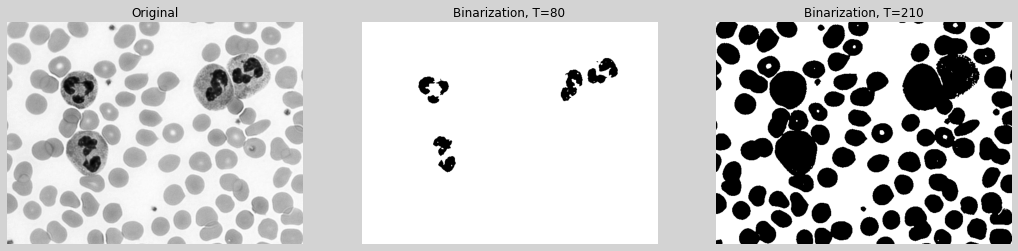

In [172]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title=f"Binarization, T={int(T1)}").axis("off")
plt.imshow(destination1, "gray")

plt.subplot(133, title=f"Binarization, T={int(T2)}").axis("off")
plt.imshow(destination2, "gray")

plt.show()

In [173]:
# 트랙바 사용
def on_threshold(value):
    _, result = cv2.threshold(
        src=source,
        thresh=value,
        maxval=255,
        type=cv2.THRESH_BINARY
        )
    cv2.imshow("Binarization", result)

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Binarization")
cv2.createTrackbar("Threshold", "Binarization", 210, 255, on_threshold)
on_threshold(210)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #2: Automatic Binarization</font>

<hr>

### Step #1: Method
<hr>

- Otsu 이진화 방법
    - 입력 영상이 배경(background)과 객체(object) 두 개로 구성되어 있다고 가정한다. -> Bimodal histogram
        - i.e., 이 방법은 입력 영상의 픽셀 값 분포가 두 개의 부류로 구분되는 경우에 최적의 임계값을 결정하는 알고리즘이다. 일종의 최적화 알고리즘(optimization algorithm)
    - 임의의 임계값 T에 의해 나눠지는 두 픽셀 분포 그룹의 분산이 최소가 되는 T를 선택한다.
    - cv2.THRESH_OTSU 상수는 보통 논리합 연산자(|)를 이용하여 앞서 '영상의 이진화'에서 소개한 다섯 개의<br>
    ThresholdTypes 상수와 함께 사용된다.
        - e.g., 만약 threshold() 함수의 type 파라미터에 THRESH_OTSU 상수만 지정하면<br>
        알고리즘에 의해 자동으로 임계값을 결정하고, THRESH_BINARY 방법으로 이진화를 수행한다.
    - 자동 이진화를 수행할 경우, threshold() 함수 내부에서 임계값을 자체적으로 계산하여 사용하기 때문에<br>
    threshold() 함수의 세 번째 파라미터 thresh 에 전달한 값은 사용되지 않는다.
    - <img src="images/markdown/Otsu_binarization.png" width="500">

$$\text{Within-class variance:}\quad
\sigma_{Within}^2(t)=\omega_{1}(t)\sigma_{1}^2(t)+\omega_{2}(t)\sigma_{2}^2(t)$$

$$\omega_{1}(t)=\sum_{i=0}^t p(i)\ ,\quad\omega_{2}(t)=\sum_{i=t+1}^{L-1} p(i)$$

$$\omega_{1}(t):\ {\scriptstyle\text{1번 클래스 가중치}},\ 
\omega_{2}(t):\ {\scriptstyle\text{2번 클래스 가중치}},\ 
p(i):\ {\scriptstyle\text{픽셀 값 i가 나타날 확률(정규화된 히스토그램 값)}}$$

$$\text{Otsu Threshold:}\quad T=\text{argmin}\ \sigma_{Within}^2(t)$$

- Within-class variance 최소화 -> Between-class variance 최대화

$$\begin{align}\sigma_{Between}^2(t)
&=\sigma^2-\sigma_{Within}^2(t)\\
&=\omega_{1}(t)(1-\omega_{1}(t))(\mu_{1}(t)-\mu_{2}(t))^2
\end{align}$$

- 모든 t값에 대해 Between-class variance 를 구하여 최적의 T를 선택하는 방법 -> Slow
- Recursion을 이용한 효율적 계산 방법 -> Fast

$$\omega_1 (0)=p(0),\mu_1 (0)=0$$
$$\omega_1 (t)=\omega_1 (t-1)+p(t)$$
$$\mu_1 (t)=\frac{\omega_1 (t-1)\mu_1 (t-1)+tp(t)}{\omega_1 (t)}
\quad\quad
\mu_2 (t)=\frac{\mu-\omega_1 (t)\mu_1 (t)}{1-\omega_1 (t)}$$

<img src="images/markdown/Otsu_binarization2.png" width="600">

- Image from [https://en.wikipedia.org/wiki/Otsu%27s_method](https://en.wikipedia.org/wiki/Otsu%27s_method)

<hr>

### Step #2: implementation example
<hr>

In [174]:
# Automatic binarization using Otsu method - Otsu 방법을 이용한 자동 이진화
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)

# or 연산자를 통해 cv2.THRESH_BINARY 플래그를 지정하지 않으면 cv2.THRESH_BINARY로 수행한다.
# 한편, inverse된 이진화 영상을 얻고 싶으면 cv2.THRESH_BINARY_INV 플래그를 or 연산자로 묶어서 지정하면 된다.
value, destination = cv2.threshold(source, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:", value)

otsu's threshold: 131.0


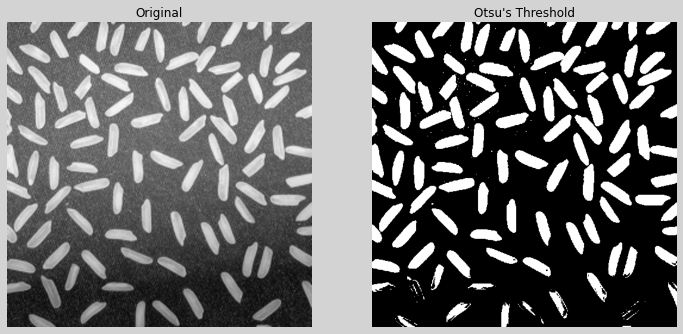

In [175]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Otsu's Threshold").axis("off")
plt.imshow(destination, "gray")

plt.show()

#### NOTE: 조명이 뷸균일하여 영상의 하단 부분은 이진화가 정확하게 되지 않는 모습을 볼 수 있다.

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Otsu's Threshold", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #3: Local Binarization</font>

<hr>

### Step #1: Concept
<hr>

- 용어(global vs local vs adaptive)
    - 앞서 공부한 threshold() 함수는 지정한 임계값을 영상 전체 픽셀에 동일하게 적용하여 이진화 영상을 생성한다.<br>
    이처럼 영상의 모든 픽셀에 같은 임계값을 적용하여 이진화를 수행하는 방식을 전역 이진화(global binarization)라고 한다.
    - 불균일한 조명 성분을 가지고 있는 영상에 대해서는 하나의 임계값으로 객체와 배경을 재대로 구분하기 어렵기 때문에<br>
    각 픽셀마다 서로 다른 임계값을 사용하는 방법을 적응형 이진화(adaptive binarization) 기법이라 하고, 영상을<br>
    n x n개의 형태로 분할하여 각각의 구역마다 이진화를 수행하는 방식을 지역 이진화(local binarization)라고 한다.
- 지역 이진화(분할 이진화)
    - 전체 영상을 균일한 크기로 n x n등분. 각각의 구역마다 따로 이진화를 수행(n x n번 수행)하고 이어 붙인다.
- 적응형 이진화(OpenCV 지원)
    - OpenCV에서는 지역 이진화를 수행하기 위한 하나의 방법으로 적응형 이진화 방법을 제공한다.
    - 적응형 이진화는 영상의 모든 픽셀에서 정해진 크기의 사각형 블록 영역을 설정하고, 블록 영역 내부의<br>
    픽셀 값 분포로부터 고유의 임계값을 결정하여 이진화를 수행한다. 이때 (x,y) 좌표에서의 임계값 T(x,y)는<br>
    다음 수식을 이용하여 결정한다.
        - T(x,y) = E(x,y) - C
    - 위 수식에서 E(x,y)는 (x,y) 주변 블록 영역의 픽셀 값 평균이고, C는 임계값의 크기를 조정하는 상수이다.
    - 블록 내부 픽셀 값의 평균 E(x,y)는 일반적인 산술 평균을 사용하거나 또는 가우시안 함수 형태의 가중치를 적용한<br>
    가중 평균을 사용한다.
    - 상수 C는 영상의 특성에 따라 사용자가 결정한다.

<hr>

### Step #2: Implementation example of local binarization
<hr>

In [1]:
# Local binarization example - 지역 이진화 예제
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)


# 입력 영상을 가로 4 세로 4 총 16 등분하여 각각 이진화
def local_binarization(image, value):
    result = np.zeros(image.shape, np.uint8)
    
    block_width = image.shape[1] // value
    block_height = image.shape[0] // value
    
    for y in range(value):
        for x in range(value):
            image_ = image[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            result_ = result[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            cv2.threshold(image_, 0, 255, cv2.THRESH_OTSU, result_)
            
    return result


destination = local_binarization(source, 4)

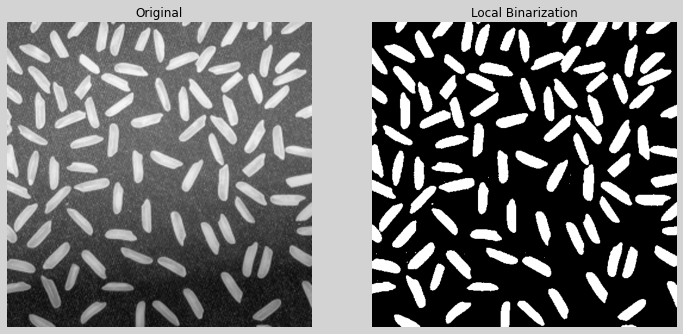

In [177]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Local Binarization").axis("off")
plt.imshow(destination, "gray")

plt.show()

In [ ]:
# 트랙바 사용하기
def on_trackbar(value):
    if value == 0:
        value = 1
    elif value > 1 and value % 2:
        value -= 1
    
    # 입력 영상을 가로, 세로 value 만큼 총 value x value 등분하여 각각 이진화
    destination = local_binarization(source, value)
    
    cv2.imshow("Local Binarization", destination)

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Local Binarization")
cv2.createTrackbar("window ratio", "Local Binarization", 4, 20, on_trackbar)
on_trackbar(4)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

<hr>

### Step #3: OpenCV function
<hr>

> `OpenCV 적응형 이진화 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}adaptiveThreshold}(src, maxValue, adaptiveMethod, thresholdType, blockSize, C, dst)\rightarrow dst}$$
- src: source. `입력 그레이스케일 영상`
- maxValue: 이진화 결과 영상의 최댓값.
- adaptiveMethod: 블록 평균 계산 방법 지정
- thresholdType: cv2.THRESH_BINARY 또는 cv2.THRESH_BINARY_INV 둘 중 하나를 지정한다.
- blockSize: 임계값 계산 시 사용하는 블록 크기. 3이상의 홀수를 지정해야 한다.
- C: 임계값 조정을 위한 상수
- dst: destination. 결과 영상. src와 같은 크기, 같은 타입이다.
- `참고사항:`
    - maxValue: 객체와 배경을 더 효과적으로 분할하기 위해 보통 255로 지정한다.
    - adaptiveMethod: ADAPTIVE_THRESH_MEAN_C or ADAPTIVE_THRESH_GAUSSIAN_C<br>
    두 가지 방법중에 하나를 고를수 있다.
        - cv2.ADAPTIVE_THRESH_MEAN_C: `blockSize x blockSize` 크기의 주변 영역 픽셀로부터<br>
        산술 평균을 구한다.
        - cv2.ADAPTIVE_THRESH_GAUSSIAN_C: 각 픽셀 주변에 `blockSize x blockSize` 크기의<br>
        가우시안 마스크를 적용하여 가우시안 가중치 평균을 계산한다.
    - thresholdType: cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV 이외의 방법은 적응형 이진화를<br>
    사용하는 의미가 없다.
    - blockSize: (x,y)에서의 픽셀을 고정점(anchor point)으로 하는 blockSize x blockSize 크기의<br>
    영역이 마치 필터링 함수의 커널처럼 `모든 픽셀`을 지나치며 이진화를 수행한다.
    - C: 임의의 좌표(x,y) 픽셀의 임계값으로 블록 평균에서 C를 뺀 값을 임계값으로 사용한다.

In [ ]:
import cv2
help(cv2.adaptiveThreshold)

<hr>

### Step #3-1: Implementation example of adaptive binarization
<hr>

In [178]:
# Adaptive binarization example - 적응형 이진화 예제
import cv2
import numpy as np

source = cv2.imread("images/sudoku.jpg", cv2.IMREAD_GRAYSCALE)

destination = cv2.adaptiveThreshold(
        src=source,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=91,
        C=5
        )

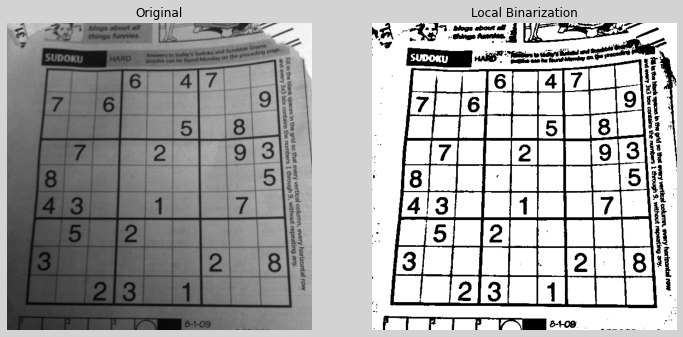

In [179]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Local Binarization").axis("off")
plt.imshow(destination, "gray")

plt.show()

In [ ]:
# 트랙바 사용하기
def on_trackbar(value):
    block_size = 3 if value < 3 else value if value % 2 else value - 1
    
    destination = cv2.adaptiveThreshold(
        source, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, 5
        )
    
    cv2.imshow("Local Binarization", destination)

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.namedWindow("Local Binarization")
cv2.createTrackbar("block size", "Local Binarization", 5, 100, on_trackbar)
on_trackbar(5)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #4: Morphology</font>

<hr>

### Step #1: Morphology operation
<hr>

- 모폴로지 연산
    - 영상을 형태학적인 측면에서 내부 객체의 형태와 구조를 분석하고 처리하는 기법이다.
    - 그레이스케일 영상과 이진 영상에 모두 적용이 가능하지만, 주로 이진화된 영상에서 객체의 모양을 단순화시키거나<br>
    잡음을 제거하는 등 용도로 사용된다.
    - 다양한 영상 처리 시스템에서 전처리(pre-processing) 또는 후처리(post-processing) 형태로 널리 사용된다.
    - 수학적 모폴로지(mathematical morphology)
- 구조 요소(Structuring element)
    - 모폴로지 연산의 결과를 결정하는 커널, 마스크, 윈도우
    - 3x3 정방형 행렬이 가장 많이 쓰인다.
    - 모폴로지 연산 결과가 저장될 위치를 나타내는 점을 고정점(anchor point)이라고 하며, 대부분의 경우<br>
    구조 요소의 중심을 고정점으로 사용한다.
    - <img src="images/markdown/structuring_element.png" width="500">

<hr>

### Step #2: Erosion & Dilation
<hr>

- 이진 영상의 침식(erosion) 연산
    - 이진 영상의 침식 연산은 객체 영역의 외곽을 골고루 깎아 내는 연산으로 전체적으로 객체 영역은 축소되고 배경은 확대된다.
    - 침식 연산은 구조 요소를 영상 전체에 대해 스캔하면서, 구조 요소가 객체 영역 내부에 완전히 포함될 경우<br>
    고정점 위치 픽셀을 255로 설정한다.
    - <img src="images/markdown/erosion.png" width="500">

<hr>

- 이진 영상의 팽창(dilation) 연산
    - 팽창 연산은 객체 외곽을 확대시키는 연산으로 전체적으로 객체 영역은 확대되고 배경은 축소된다.
    - 팽창 연산은 구조 요소를 영상 전체에 대해 이동시키면서, 구조 요소와 객체 영역이 한 픽셀이라도 만날 경우<br>
    고정점 위치 픽셀을 255로 설정한다.
    - <img src="images/markdown/dilation.png" width="500">

<hr>

### Step #2-1: OpenCV function
<hr>

> `모폴로지 구조 요소(커널) 생성 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}getStructuringElement}(shape, ksize, anchor)\rightarrow retval}$$
- shape: 구조 요소 모양을 나타내는 cv2.MORPH_ 로 시작하는 플래그
- ksize: kernel size. 구조 요소 크기. (width, height) 튜플 형태
- anchor: MORPH_CROSS 모양의 구조 요소에서 고정점 좌표를 나타낸다.<br>
- retval: return value. 0과 1로 구성된 cv2.CV_8UC1 타입의 행렬
- `참고사항:`
    - shape:
        - <img src="images/markdown/structuring_element_shape.png" width="400">
    - anchor: (-1, -1)을 지정하면 구조 요소의 중앙을 고정점으로 사용한다.
        - `기본값은 (-1, -1)`
    - retval: 1의 위치가 구조 요소의 모양을 결정한다.
        - dtype=`numpy.ndarray`

<hr>

> `모폴로지 침식 연산 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}erode}(src, kernel, dst, anchor, iterations, borderType, borderValue)\rightarrow dst}$$
- src: source. 입력 영상
- kernel: 구조 요소. getstructuringElement() 함수에 의해 생성 가능.
- dst: destination. 출력 영상. src와 동일한 크기와 타입
- anchor: 고정점 위치.
- iterations: 침식 연산 반복 횟수.
- borderType: 가장자리 픽셀 확장 방식.
- borderValue: borderType이 cv2.BORDER_CONSTANT인 경우, 확장된 가장자리 픽셀을 채울 값을 지정
- `참고사항:`
    - kernal: `None`을 지정하면 3x3 사각형 구성 요소를 사용한다.
    - anchor: (-1, -1)을 지정하면 구조 요소의 중앙을 고정점으로 사용한다.
        - `기본값은 (-1, -1)`
    - iterations: `기본값은 1`
    - borderType: `기본값은 cv2.BORDER_CONSTANT`

<hr>

> `모폴로지 팽창 연산 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}dilate}(src, kernel, dst, anchor, iterations, borderType, borderValue)\rightarrow dst}$$
- src: source. 입력 영상
- kernel: 구조 요소. getstructuringElement() 함수에 의해 생성 가능.
- dst: destination. 출력 영상. src와 동일한 크기와 타입
- anchor: 고정점 위치.
- iterations: 팽창 연산 반복 횟수.
- borderType: 가장자리 픽셀 확장 방식.
- borderValue: borderType이 cv2.BORDER_CONSTANT인 경우, 확장된 가장자리 픽셀을 채울 값을 지정
- `참고사항:`
    - kernal: `None`을 지정하면 3x3 사각형 구성 요소를 사용한다.
    - anchor: (-1, -1)을 지정하면 구조 요소의 중앙을 고정점으로 사용한다.
        - `기본값은 (-1, -1)`
    - iterations: `기본값은 1`
    - borderType: `기본값은 cv2.BORDER_CONSTANT`

In [ ]:
import cv2
help(cv2.getStructuringElement)

In [ ]:
import cv2
help(cv2.erode)

In [ ]:
import cv2
help(cv2.dilate)

<hr>

### Step #2-2: Implementation example
<hr>

In [180]:
# Example a erosion & dilation of binary image - 이진 영상의 침식과 팽창 예제
import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/circuit1.bmp", cv2.IMREAD_GRAYSCALE)

structur = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
destination1 = cv2.erode(source, structur)

structur = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 7))
destination2 = cv2.dilate(source, structur)

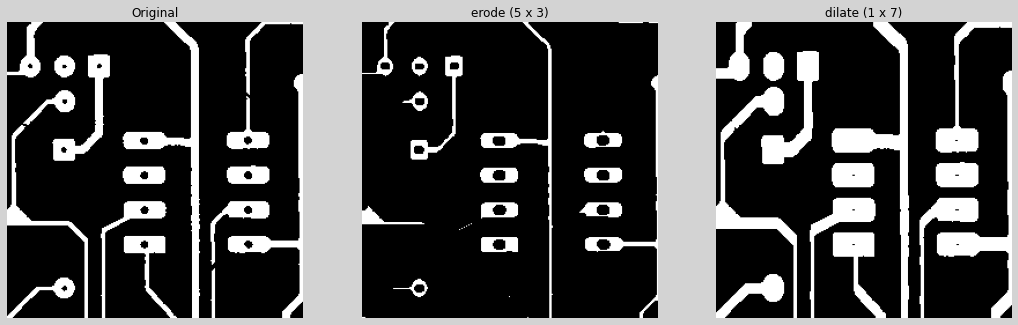

In [181]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="erode (5 x 3)").axis("off")
plt.imshow(destination1, "gray")

plt.subplot(133, title="dilate (1 x 7)").axis("off")
plt.imshow(destination2, "gray")

plt.show()

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("erode (5 x 3)", destination1)
cv2.imshow("dilate (1 x 7)", destination2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

<hr>

### Step #3: Opening & Closing
<hr>

- 이진 영상의 열기(opening) 연산
    - 입력 영상에 대하여 침식 연산을 수행한 후, 다시 팽창 연산을 수행하는 연산이다.
    - 침식 연산을 먼저 수행하기 때문에 한두 픽셀짜리 영역이 제거된 후, 팽창 연산이 수행된다.<br>
    그 결과 입력 이진 영상에 존재하는 작은 크기의 객체가 효과적으로 제거된다.

<hr>

- 이진 영상의 닫기(closing) 연산
    - 입력 영상에 대하여 팽창 연산을 수행한 후, 다시 침식 연산을 수행하는 연산이다.
    - 팽창 연산을 먼저 수행하기 때문에 객체 내부의 작은 구멍이 매워진 후, 침식 연산이 수행된다.<br>
    그 결과 입력 이진 영상의 객체 내부의 작은 구멍을 제거한다.

<hr>

- 열기와 닫기 연산 효과(3x3 구조 요소 사용)
    - <img src="images/markdown/open_and_close_operation.png" width="500">

<hr>

### Step #3-1: OpenCV function
<hr>

> `범용 모폴로지 연산 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}morphologyEx}(src, op, kernel, dst, anchor, iterations, borderType, borderValue)\rightarrow dst}$$
- src: source. 입력 영상
- op: operation. 모폴로지 연산 타입 플래그
- kernel: 구조 요소. getstructuringElement() 함수에 의해 생성 가능.
- dst: destination. 출력 영상. src와 동일한 크기와 타입
- anchor: 고정점 위치.
- iterations: 침식 연산 반복 횟수.
- borderType: 가장자리 픽셀 확장 방식.
- borderValue: borderType이 cv2.BORDER_CONSTANT인 경우, 확장된 가장자리 픽셀을 채울 값을 지정
- `참고사항:`
    - op:
        - <img src="images/markdown/morphology_operation_type.png" width="500">
    - kernel: `None`을 지정하면 3x3 사각형 구성 요소를 사용한다.
    - anchor: (-1, -1)을 지정하면 구조 요소의 중앙점을 사용한다.
        - `기본값은 (-1, -1)`
    - iterations: `기본값은 1`
    - borderType: `기본값은 cv2.BORDER_CONSTANT`

In [ ]:
import cv2
help(cv2.morphologyEx)

<hr>

### Step #3-2: Implementation example
<hr>

In [13]:
# noise removal example using opening operation - 열기 연산을 이용한 잡음 제거 예제
import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/rice.png", cv2.IMREAD_GRAYSCALE)


def local_binarization(image, value):
    result = np.zeros(image.shape, np.uint8)
    
    block_width = image.shape[1] // value
    block_height = image.shape[0] // value
    
    for y in range(value):
        for x in range(value):
            image_ = image[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            result_ = result[
                y * block_height:(y+1) * block_height,  # rows
                x * block_width:(x+1) * block_width     # cols
                ]
            cv2.threshold(image_, 0, 255, cv2.THRESH_OTSU, result_)

    print("Local Binarization is done!")
    return result


# 열기 연산 전후에 감지된 객체 수 출력
destination = local_binarization(source, 4)
count1, _ = cv2.connectedComponents(destination)
print("before opening operation:", count1)

opening = cv2.morphologyEx(destination, cv2.MORPH_OPEN, None)
count2, _ = cv2.connectedComponents(opening)
print("after opening operation:", count2)

Local Binarization is done!
before opening operation: 113
after opening operation: 99


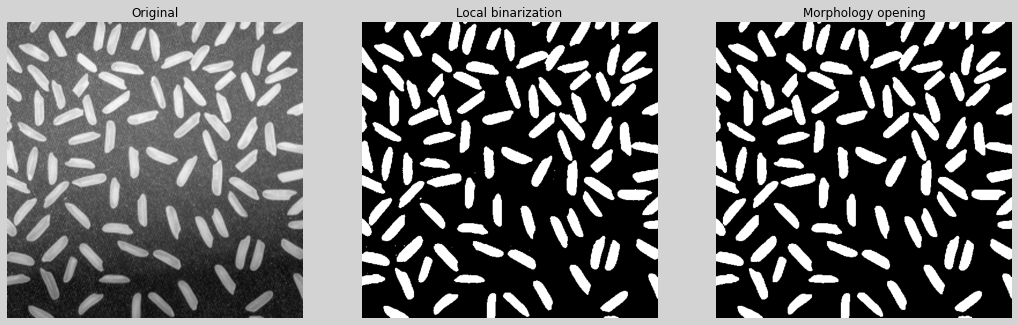

In [183]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="Local binarization").axis("off")
plt.imshow(destination, "gray")

plt.subplot(133, title="Morphology opening").axis("off")
plt.imshow(opening, "gray")

plt.show()

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Local binarization", destination)
cv2.imshow("Morphology opening", opening)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Case #5: Labeling</font>

<hr>

### similar concept
<hr>

- 객체 단위 분석
    - (흰색) 객체를 분할하여 특징을 분석한다.
    - 객체 위치 및 크기 정보, ROI 추출, 모양 분석 등
- 레이블링(Connected Component Labeling)
    - 서로 연결되어 있는 객체 픽셀에 고유한 번호를 지정한다.(레이블맵)
    - 영역 기반 모양 분석
    - 레이블맵, 바운딩 박스, 픽셀 개수, 무게 중심 좌표를 반환한다.
- 외곽선 검출(Contour Tracing)
    - 각 객체의 외곽선 좌표를 모두 검출한다.
    - 외곽선 기반 모양 분석
    - 다양한 외곽선 처리 함수에서 활용 가능하다.(근사화, 컨벡스헐 등)

<hr>

### Step #1: Concept
<hr>

- 레이블링
    - 동일 객체에 속한 모든 픽셀에 고유한 번호를 매기는 작업이다.
    - 레이블링 기법을 이용하여 각 객체의 위치와 크기 등 정보를 추출하는 작업은<br>
    객체 인식을 위한 전처리 과정으로 자주 사용된다.
    - 일반적으로 이진 영상에서 수행한다. 이때 검은색 픽셀은 배경으로 간주하고, 흰색 픽셀은 객체로 간주한다.
        - i.e., 정확하게는 입력 영상의 픽셀 값이 0이면 배경, 0이 아니면 객체 픽셀로 인식한다.<br>
        하나의 객체는 한 개 이상의 인접한 픽셀로 이루어지며, 하나의 객체를 구성하는 모든 픽셀에는<br>
        같은 레이블 번호가 지정된다.
    - 속도면에서 레이블링이 외곽선 검출보다 연산이 더 빠르고 효율적이다.
    - OpenCV에는 3.x 버전부터 최신 논문 기반의 레이블링 알고리즘 함수를 제공한다.
    - 연경된 구성 요소 레이블링(Connected component labeling)이라고도 한다.

<hr>

- 픽셀의 연결 관계
    - 특정 픽셀과 이웃한 픽셀의 연결 관계는 크게 두 가지 방식으로 정의할 수 있다.
        - 4-이웃 연결 관계(4-neighbor connectivity)
            - 특정 픽셀의 상하좌우로 붙어 있는 픽셀끼리 연결되어 있다고 정의한다.
            - <img src="images/markdown/4-neighbor_connectivity.png" width="250">
        - 8-이웃 연결 관계(8-neighbor connectivity)
            - 상하좌우로 연결된 픽셀뿐만 아니라 대각선 방향으로 인접한 픽셀도 연결되어 있다고 간주한다.
            - <img src="images/markdown/8-neighbor_connectivity.png" width="250">

<hr>

### Step #2: Labeling in-output example
<hr>

- 레이블링 알고리즘의 입력과 출력
    - <img src="images/markdown/labeling_example.png" width="500">

<hr>

### Step #3: OpenCV function
<hr>

> `레이블링 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}connectedComponents}(image, labels, connectivity, ltype)\rightarrow retval, labels}$$
- image: 입력 영상. CV_8UC1 or CV_8SC1(그레이스케일, 이진 영상)
- labels: 레이블 맵 행렬.
- connectivity: 연결 관계 지정.
- ltype: lebels type. 출력 행렬 타입
- retval: return value. 객체 개수.
- `참고사항:`
    - image: 회색이 포함된 그레이스케일 영상을 입력으로 사용할 경우, 픽셀 값이 0이 아니면 객체 픽셀로 간주한다.
    - labels: 입력 영상과 같은 크기이다.
        - type=`numpy.ndarray`
    - connectivity: 4 또는 8을 지정할 수 있다.
        - `기본값은 8`
    - ltype: cv2.CV_32S or cv2.CV_16S 를 지정할 수 있다.
        - `기본값은 cv2.CV_32S`
    - retval: 반환값이 N이면 0부터 N-1까지 레이블 번호가 존재하며, 이 중 0번 레이블은 배경을 나타내기 때문에<br>
    실제 객체 개수는 N-1개이다.
<hr>

> `객체 정보를 함께 반환하는 레이블링 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}connectedComponentsWithStats}(image, labels, stats, centroids, connectivity, ltype)\rightarrow retval, labels, stats, centroids}$$
- image: 입력 영상. CV_8UC1 or CV_8SC1(그레이스케일, 이진 영상)
- labels: 레이블 맵 행렬.
- stats: 각 객체의 바운딩 박스. 각각의 레이블 영역에 대한 통계 정보를 담은 행렬
- centroids: 각 객체의 무게 중심 위치 정보를 담은 행렬
- connectivity: 연결 관계 지정.
- ltype: lebels type. 출력 행렬 타입
- retval: return value. 객체 개수
- `참고사항:`
    - retval: 반환값이 N이면 0부터 N-1까지 레이블 번호가 존재하며, 이 중 0번 레이블은 배경을 나타내기 때문에<br>
    실제 객체 개수는 N-1개이다.
    - labels: 입력 영상과 같은 크기이다.
        - type=`numpy.ndarray`
    - stats: 
        - type=`numpy.ndarray`
        - shape=`(N, 5)`
        - dtype=`numpy.int32`
    - centroinds:
        - type=`numpy.ndarray`
        - shape=`(N, 2)`
        - dtype=`numpy.float64`
    - connectivity: 4 또는 8을 지정할 수 있다.
        - `기본값은 8`
    - ltype: cv2.CV_32S or cv2.CV_16S 를 지정할 수 있다.
        - `기본값은 cv2.CV_32S`

In [ ]:
import cv2
help(cv2.connectedComponents)

In [ ]:
import cv2
help(cv2.connectedComponentsWithStats)

<hr>

### Step #4: Example
<hr>

<img src="images/markdown/labeling_function_example.png" width="600">

<hr>

### Step #5: Implementation example
<hr>

In [ ]:
# Labeling example - 레이블링 예제
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/keyboard.bmp", cv2.IMREAD_GRAYSCALE)

_, binarization = cv2.threshold(source, 0, 255, cv2.THRESH_OTSU)

binarization = cv2.morphologyEx(binarization, cv2.MORPH_OPEN, None)  # 노이즈 제거

count, labels, stats, centroids = cv2.connectedComponentsWithStats(binarization)

destination = cv2.cvtColor(source, cv2.COLOR_GRAY2BGR)

# print(len(np.unique(labels[labels > 0])))  # 객체 수: 18개
for i in range(1, 19):
    num1 = random.randint(0, 255)
    num2 = random.randint(0, 255)
    num3 = random.randint(0, 255)
    destination[labels == i] = (num1, num2, num3)

for i in range(1, count):
    x, y, w, h, _ = stats[i]
    
    center_x = round(centroids[i][0])
    center_y = round(centroids[i][1])
    
    cv2.rectangle(destination, (x, y, w, h), (0, 255, 0), 1, cv2.LINE_AA)
    
    destination[center_y-1:center_y+2, center_x-1:center_x+2] = (0, 255, 0)  # 중심점 표시

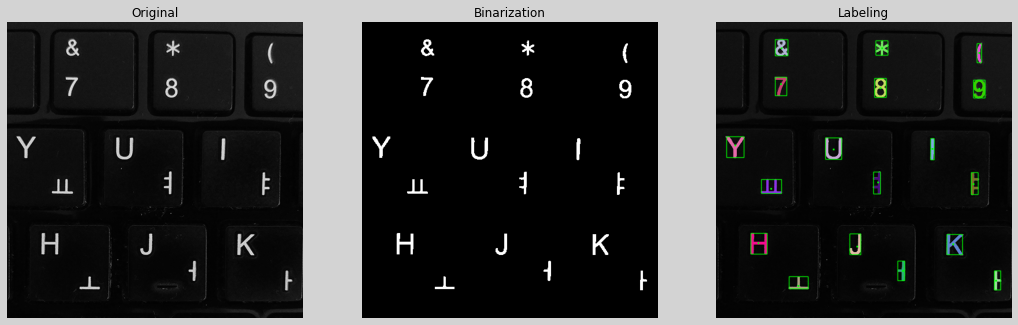

In [94]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="Binarization").axis("off")
plt.imshow(binarization, "gray")

plt.subplot(133, title="Labeling").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [93]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Binarization", binarization)
cv2.imshow("Labeling", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## <font color = "#CC3D3D">Case #6: Contour Tracing</font>

<hr>

### Step #1: Concept
<hr>

- 외곽선 검출
    - OpenCV의 외곽선 검출 기능은 객체의 외곽선 픽셀 좌표를 모두 추출하여 계층 정보와 함께 반환한다.
    - 객체의 외곽선(Contour)은 객체 영역 픽셀 중에서 배경 영역과 인접한 일련의 픽셀을 의미한다.
        - 보통 검은색 배경 안에 있는 흰색 객체 영역에서 가장 최외곽에 있는 픽셀을 찾아 외곽선으로 정의한다.
        - 만약 흰색 객체 영역 안에 검은색 배경 영역인 홀(hole)이 존재한다면 홀을 둘러싸고 있는 객체 픽셀들도<br>
        외곽선으로 검출할 수 있다.
        - 즉, 객체의 외곽선은 객체 바깥쪽 외곽선과 안쪽 홀 외곽선으로 구분할 수 있다.
    - 객체 하나의 외곽선은 여러 개의 점으로 구성된다. 그러므로 객체 하나의 외곽선 정보는<br>
    `numpy.ndarray`로 구성된 리스트이다. 또한 하나의 영상에는 여러 개의 객체가 존재할 수 있으므로<br>
    영상 하나에서 추출된 전체 객체의 외곽선 정보는 리스트들의 리스트로 이루어져 있다.

<hr>

- 외곽선 객체 하나의 표현 방법
    - type=`numpy.ndarray`
    - shape=`(K, 1, 2)`
        - K는 하나의 객체에 존재하는 여러 개의 외곽선 좌표 개수
    - dtype=`numpy.int32` -> OpenCV 표현 방법: `cv2.CV_32S`

<hr>

- 여러 외곽선 객체의 표현 방법
    - "객체 하나의 외곽선(numpy.ndarray)"을 원소로 갖는 `리스트`
    - `리스트`의 길이 = 전체 외곽선 객체 수(N)
        - `참고사항:` 레이블링에서는 배경까지 하나의 객체로 인식하여 전체 객체의 수는 N-1개인 반면에<br>
        외곽선 검출에서는 배경을 객체로 인식하지 않기 때문에 전체 객체의 수는 N개이다.

<hr>

### Step #2: OpenCV function
<hr>

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}findContours}(image, mode, method, contours, hierarchy, offset)\rightarrow contours, hierarchy}$$
- image: 입력 영상
- mode: 외곽선 검출 모드. `RetrievalModes` 열거형 상수 지정
- method: 외곽선 근사화 방법. `ContourApproximationModes` 열거형 상수 지정
- contours: 검출된 외곽선 좌표
- hierarchy: 외곽선 계층 정보
- offset: 외곽선 점 좌표의 이동 변위 오프셋
- `참고사항:`
    - image: 8비트 1채널 영상이여야 하며, 0이 아닌(non-zero) 픽셀을 객체로 간주한다.
        - 만약 mode가 `cv2.RETR_CCOMP`라면 `CV_32SC1` 타입의 영상을 입력 영상으로 지정할 수 있다.
    - mode: `cv2.RETR_`로 시작하는 플래그
    - method: `cv2.CHAIN_APPROX_`로 시작하는 플래그
    - contours: 외곽선 객체들로 구성된 튜플이고, 각각의 외곽선 객체(배열)안에는<br>
    해당 객체의 모든 외곽선 점들의 좌표정보가 담겨있다.
        - type=`numpy.ndarray`
        - len(contours)=전체 외곽선 객체 수(N)
        - contours[i].shape=`(K, 1, 2)`
        - contours[i].dtype=`numpy.int32` -> OpenCV 표현 방법: `cv2.CV_32S`
    - hierarchy: 각각의 외곽선 객체의 계층 정보를 담고 있는 리스트이고,<br>
    순서대로 next, prev, child, parent 외곽선의 인덱스를 가리키고 있다.(e.g., 해당 외곽선이 없으면 -1로 표시된다.)
        - 한 개 이상의 child 외곽선이 존재할 시 인덱스로 대표값이 하나만 표시된다.
        - type=`numpy.ndarray`
        - shape=`(1, N, 4)`
        - dtype=`numpy.int32` -> OpenCV 표현 방법: `cv2.CV_32S`
    - offset: `기본값은 (0, 0)`

<hr>

<img src="images/markdown/RetrievalModes_constants.png" width="600">

<img src="images/markdown/ContourApproximationModes_constants.png" width="600">

In [ ]:
import cv2
help(cv2.findContours)

<hr>

### Step #2-1: OpenCV function for drawing contours
<hr>

> `외곽선 그리기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}drawContours}(image, contours, contourIdx, color, thickness, lineType, hierarchy, maxLevel, offset)\rightarrow image}$$
- image: 입출력 영상
- contours: (cv2.findContours() 함수로 구한) 외곽선 좌표 정보
- contourIdx: 외곽선 인덱스.
- color: 외곽선 색상
- thickness: 외곽선 두께
- lineType: 외곽선 타입
- hierarchy: (cv2.findContours() 함수로 구한) 외곽선 계층 정보
- maxLevel: 그리기를 수행할 최대 외곽선 레벨
- `참고사항:`
    - contourIdx: -1을 지정하면 모든 외곽선을 그린다.
    - thickness: -1을 지정하면 내부를 지정한 색상으로 채운다.
    - lineType: cv2.LINE_4, cv2.LINE_8, cv2.LINE_AA 중 하나를 지정한다.
    - maxLevel: 사용 가능한 계층 정보가 있는 경우에만 고려된다.
        - `기본값은 0.` 0을 지정하면 contourIdx로 지정된 외곽선만 그린다.
        - 1이상을 지정하면 그에 해당하는 하위 레벨의 외곽선까지 그린다.

In [ ]:
import cv2
help(cv2.drawContours)

<hr>

### Step #3: Implementation example
<hr>

In [ ]:
# Contours detection example with hierarchy - 계층 정보를 사용하는 외곽선 검출 예제
import random

import cv2
import matplotlib.pyplot as plt

source = cv2.imread("images/contours.bmp", cv2.IMREAD_GRAYSCALE)

contours, hierarchy = cv2.findContours(source, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

destination = cv2.cvtColor(source, cv2.COLOR_GRAY2BGR)

index = 0
while index != -1:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(destination, contours, index, color, 2, cv2.LINE_AA, hierarchy)
    index = hierarchy[0, index, 0]

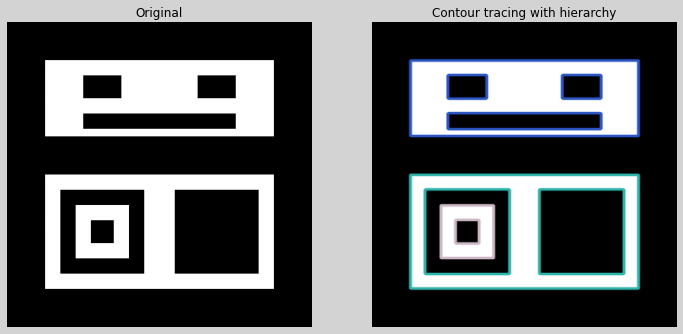

In [258]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(122, title="Contour tracing with hierarchy").axis("off")
plt.imshow(destination, "gray")

plt.show()

In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Original", source)
cv2.imshow("Contour tracing", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

In [38]:
# Contours detection example without hierarchy - 계층 정보를 사용하지 않는 외곽선 검출 예제
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

source = cv2.imread("images/milkdrop.bmp", cv2.IMREAD_GRAYSCALE)

_, binarization = cv2.threshold(source, 0, 255, cv2.THRESH_OTSU)

contours, _ = cv2.findContours(binarization, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

HEIGHT, WIDTH = source.shape
destination = np.zeros((HEIGHT, WIDTH, 3), np.uint8)

for i in range(len(contours)):
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(destination, contours, i, color, 1, cv2.LINE_AA)

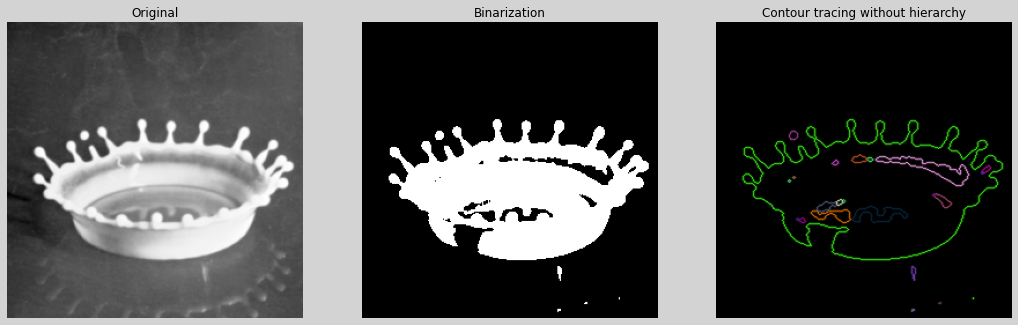

In [39]:
# pyplot으로 출력
plt.figure(figsize=(18, 6), facecolor="lightgray")

plt.subplot(131, title="Original").axis("off")
plt.imshow(source, "gray")

plt.subplot(132, title="Binarization").axis("off")
plt.imshow(binarization, "gray")

plt.subplot(133, title="Contour tracing without hierarchy").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [239]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("src", source)
cv2.imshow("bi", binarization)
cv2.imshow("dst", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

<hr>

### Step #4: Diverse contour-related OpenCV function
<hr>

- 외곽선 관련 함수들

<img src="images/markdown/contour-related_functions.png" width="600">

<hr>

> `외곽선 길이 구하기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}arcLength}(curve, closed)\rightarrow retval}$$
- curve: 검출된 객체의 외곽선 좌표 배열
- closed: 폐곡선 여부
- retval: return value. 외곽선 길이
- `참고사항:`
    - curve:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`
    - closed: True이면 폐곡선으로 간주

<hr>

> `객체의 면적(외곽선이 감싸는 영역) 구하기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}contourArea}(contour, oriented)\rightarrow retval}$$
- contour: 검출된 객체의 외곽선 좌표 배열
- oriented: 진행 방향 정보 사용 여부
- retval: 입력한 외곽선으로 구성된 영역의 면적
- `참고사항:`
    - contour:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`
    - oriented: True이면 외곽선 진행 방향에 따라 면적의 부호가 달라진다. False이면 면적의 절댓값을 반환한다.
        - `기본값은 False`

<hr>

> `바운딩 박스(외곽선을 외적하여 둘러싸는 가장 작은 사각형) 구하기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}boundingRect}(array)\rightarrow retval}$$
- array: 검출된 객체의 외곽선 좌표 배열
- retval: return value. 사각형 정보(x, y, w, h)가 담긴 튜플
- `참고사항:`
    - array:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`

<hr>

> `바운딩 서클(외곽선을 외접하여 둘러싸는 가장 작은 원) 구하기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}minEnclosingCircle}(points)\rightarrow center, radius}$$
- points: 검출된 객체의 외곽선 좌표 배열
- center: 바운딩 서클의 중심 좌표(x, y)가 담긴 튜플
- radius: 바운딩 서클 반지름
- `참고사항:`
    - points:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`
    - radius: dtype=`float`

<hr>

> `최소 바운딩 박스(외곽선을 감싸는 최소 크기의 회전된 사각형) 구하기 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}minAreaRect}(points)\rightarrow retval}$$
- points: 검출된 객체의 외곽선 좌표 배열
- retval: return value. 최소 크기의 회전된 사각형 정보가 담긴 튜플
- `참고사항:`
    - points:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`

<hr>

> `외곽선 근사화(단순화) 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}approxPolyDP}(curve, epsilon, closed, approxCurve)\rightarrow approxCurve}$$
- curve: 검출된 객체의 외곽선 좌표 배열
- epsilon: 근사화 정밀도 조절. 입력 곡선과 근사화 곡선 간의 최대 거리(e.g., cv2.arcLength(curve) * 0.02)
- closed: 폐곡선 여부
- approxCurve: 근사화된 곡선 좌표 배열
- `참고사항:`
    - 더글라스-포이커 알고리즘
        - [Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm)
    - curve:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`
    - closed: True이면 폐곡선으로 간주
    - approxCurve:
        - type=`numpy.ndarray`
        - shape=`(K', 1, 2)` -> K'는 근사화 이후 곡선 좌표가 이전보다 줄어들 수 있다는 의미이다.

<hr>

> `Convex 검사 함수`

$$\mathsf{{\color{RoyalBlue}cv2.}{\color{Tan}isContourConvex}(contour)\rightarrow retval}$$
- contour: 검출된 객체의 외곽선 좌표 배열
- retval: return value. Convex이면 True, 아니면 False
- `참고사항:`
    - contour:
        - type=`numpy.ndarray`
        - shape=`(K, 1, 2)`

In [ ]:
import cv2
help(cv2.arcLength)

In [ ]:
import cv2
help(cv2.contourArea)

In [ ]:
import cv2
help(cv2.boundingRect)

In [ ]:
import cv2
help(cv2.minEnclosingCircle)

In [ ]:
import cv2
help(cv2.minAreaRect)

In [ ]:
import cv2
help(cv2.approxPolyDP)

In [ ]:
import cv2
help(cv2.isContourConvex)

<hr>

### Circle discrimination
<hr>

- 원 판별하기
    - 정해진 외곽선 길이에 대한 넓이 비율이 가장 큰 형태가 원이다.<br>
    -> 도형의 넓이(A)와 외곽선 길이(P)의 비율을 검사한다.

$$\frac{A}{P}=\frac{\pi r^2}{2\pi r}\rightarrow\frac{A}{P^2}=\frac{\pi r^2}{4\pi^2 r^2}=\frac{1}{4\pi}\rightarrow 4\pi\frac{A}{P^2}=1$$
$$\cdot\ 4\pi\frac{A}{P^2}{\scriptstyle\text{값이 1에 가까울수록 원으로 판단}}$$

<hr>

### Step #4-1: Implementation example
<hr>

In [49]:
# Example a Polygons discrimination program - 다각형 판별 프로그램 예제
import math

import cv2
import matplotlib.pyplot as plt


def setLabel(image, points, label):
    rectangle = cv2.boundingRect(points)
    origin = (rectangle[:2])
    
    cv2.rectangle(image, rectangle, (0, 0, 255), 1)
    cv2.putText(image, label, origin, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 1, cv2.LINE_AA)


def convex_polygons_detector(image):
    if image is None:
        print("Image load failed!\nCheck image direction.")
        return
    
    image_copy = image.copy()
    gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    _, binarization = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for points in contours:
        if cv2.contourArea(points) < 400:
            continue
        
        length = cv2.arcLength(points, True)
        approx = cv2.approxPolyDP(points, length * 0.02, True)
        
        if len(approx) == 3:
            setLabel(image_copy, points, "TRI")
        elif len(approx) == 4:
            setLabel(image_copy, points, "RECT")
        else:
            area = cv2.contourArea(points)
            ratio = 4. * math.pi * area / (length ** 2)
            if ratio > 0.85:
                setLabel(image_copy, points, "CIR")
            elif ratio <= 0.85 and len(approx) == 8:
                setLabel(image_copy, points, "ELL")
        
    return image_copy


def non_convex_polygons_detector(image):
    if image is None:
        print("Image load failed!\nCheck image direction.")
        return
    
    image_copy = image.copy()
    gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    _, binarization = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for points in contours:
        if cv2.contourArea(points) < 400:
            continue
        
        length = cv2.arcLength(points, True)
        approx = cv2.approxPolyDP(points, length * 0.02, True)
        convex = cv2.isContourConvex(approx)
        
        if not convex:
            setLabel(image_copy, points, "POL")
        
    return image_copy

In [50]:
source = cv2.imread("images/polygon.bmp")

destination1 = convex_polygons_detector(source)
destination2 = non_convex_polygons_detector(source)

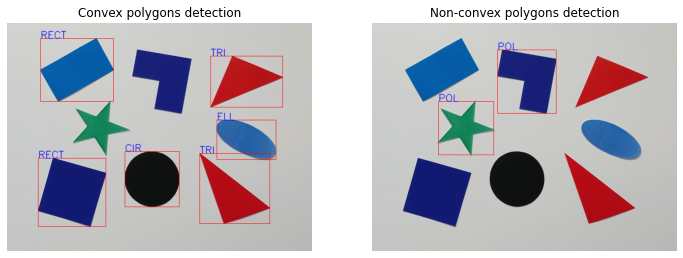

In [53]:
# pyplot으로 출력
plt.figure(figsize=(12, 6))

plt.subplot(121, title="Convex polygons detection").axis("off")
plt.imshow(destination1[:, :, ::-1])

plt.subplot(122, title="Non-convex polygons detection").axis("off")
plt.imshow(destination2[:, :, ::-1])

plt.show()

In [64]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Polygon detection", destination1)
cv2.imshow("Non-convex Polygon detection", destination2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## <font color = "#CC3D3D">Training #1: Name card recognition</font>
<hr>

- 개요
    - 영상에서 명함을 검출하고, 명함 안의 텍스트를 인식하는 프로그램
    - 가정: 명함은 흰색이고, 충분히 크게 촬영되었고, 직사각형 모양이다.
    - <img src="images/markdown/namecard_recognition_program.png" width="500">

<hr>

- 구현할 기능
    - 명함 검출
        - Otsu 자동 이진화
        - 외곽선 검출 -> 근사화 -> 사각형 검출
        - 명함의 네 모서리 점을 직사각형 네 모서리로 매핑
            - 좌측 상단 모서리점부터 반시계 방향으로 검출 및 매핑
        - 일반적인 명함의 가로:세로 비율 = 9:4
    - 명함 텍스트 인식
        - Tesseract 라이브러리 사용
        - 한글과 영문 인식

<hr>

- Tesseract
    - 광학 문자 인식(OCR) 라이브러리
    - github: [https://github.com/tesseract-ocr/tesseract](https://github.com/tesseract-ocr/tesseract)
    - 1985년~1994년 휴렛 팩커드(Hewlett-Packard)에서 개발 -> 2005년 오픈 소스 -> 2006년부터 구글에서 관리
    - 2018년 4.0이 발표되면서 LSTM(Long Short-Term Memory) 기반 OCR 엔진 및 모델이 추가됨
    - 100개 이상의 언어 데이터 제공
    - Apache License v2.0
- Mac OS 설치 가이드
    - Tesseract 설치하기
        - [homebrew](https://brew.sh/index_ko) 사이트에 접속 -> homebrew 설치
        - 터미널에서 다음 명령어를 순차적으로 입력
            - <img src="images/markdown/tesseract_installation.png" width="250">
    - pytesseract 설치하기
        - 파이썬에서 Tesseract를 사용하기 위해 필요한 패키지
        - github: [https://github.com/madmaze/pytesseract](https://github.com/madmaze/pytesseract)
        - 터미널에 `pip install pytesseract` 입력
    - OpenCV/NumPy와 사용하기
        - pytesseract는 numpy.ndarray를 지원한다.
        - pytesseract.image_to_string() 함수를 사용한다.
        - 영상 데이터를 그레이스케일 또는 색상 정보 순서를 RGB로 변경하여 지정한다.

In [1]:
# Training: namecard recognition program - 실습: 명함 인식 프로그램
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract

WIDTH = 720
HEIGHT = 400


# 목표는 4개의 꼭지점 좌표가 어떤 순서로 들어있는지와 상관없이
# 왼쪽 위 부터 반시계 방향으로 순서를 정렬 시키는 것이다.
def reorder_points(points):
    index = np.lexsort((points[:, 1], points[:, 0]))  # x좌표를 기준으로 정렬한 인덱스를 반환
    points = points[index] # 정렬된 x좌표 순서로 꼭지점 좌표를 재정렬
    
    # 1번째 꼭지점 좌표가 2번째 꼭지점 좌표보다 y값이 더 크다면 2번째 꼭지점으로 재설정
    if points[0, 1] > points[1, 1]:
        points[[0, 1]] = points[[1, 0]]
    
    # 3번째 꼭지점 좌표가 4번째 꼭지점 좌표보다 y값이 더 작다면 4번째 꼭지점으로 재설정
    if points[2, 1] < points[3, 1]:
        points[[2, 3]] = points[[3, 2]]
    
    return points


source = cv2.imread("images/namecard.jpg")

source_quad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
destination_quad = np.array([[0, 0], [0, HEIGHT], [WIDTH, HEIGHT], [WIDTH, 0]], np.float32)

destination = np.zeros((HEIGHT, WIDTH), np.uint8)

source_gray = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
_, binarization = cv2.threshold(source_gray, 0, 255, cv2.THRESH_OTSU)

contours, _ = cv2.findContours(binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

copy = source.copy()
for points in contours:
    if cv2.contourArea(points) < 400:
        continue
    
    length = cv2.arcLength(points, True)
    approx = cv2.approxPolyDP(points, length * 0.02, True)
    convex = cv2.isContourConvex(approx)
    
    if not convex or len(approx) != 4:
        continue
    
    cv2.polylines(source, [approx], True, (0, 255, 0), 1, cv2.LINE_AA)
    
    # shape=(K, 1, 2) -> shape=(K, 2)로 차원 축소 후 투시 변환을 위해 자료형을 실수형으로 변환
    approx = approx.reshape(4, 2).astype(np.float32)
    
    source_quad = reorder_points(approx)

perspective = cv2.getPerspectiveTransform(source_quad, destination_quad)
destination = cv2.warpPerspective(copy, perspective, (WIDTH, HEIGHT))

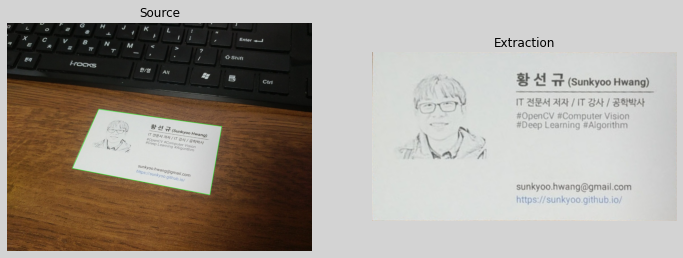

In [2]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Source").axis("off")
plt.imshow(source[:, :, ::-1])

plt.subplot(122, title="Extraction").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [3]:
# kor, kor_vert, script/Hangul, script/Hangul_vert
print("pytesseract version:", pytesseract.__version__)
print("-"*30)
print(pytesseract.image_to_string(cv2.cvtColor(destination, cv2.COLOR_BGR2GRAY), lang="kor+eng"))

pytesseract version: 0.3.8
------------------------------
황 선규 (Sunkyoo Hwang)

17 전문서 저자 / |7 강사 / 공학박사

#OpenCV #Computer Vision
#Deep Learning #Algorithm

sunkyoo.hwang@gmail.com
https://sunkyoo.github.io/



In [ ]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Source", source)
cv2.imshow("namecard", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

## <font color = "#CC3D3D">Training #2: Polygons detection</font>

In [35]:
# Training: non-convex polygons detection program - 실습: 오목한 다각형 검출 프로그램
import cv2
import matplotlib.pyplot as plt
import numpy as np


def setLabel(image, points, label):
    rectangle = cv2.boundingRect(points)
    origin = (rectangle[:2])
    
    cv2.rectangle(image, rectangle, (0, 0, 255), 1)
    cv2.putText(image, label, origin, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)


def polygons_detector(image):
    if image is None:
        print("Image load failed!\nCheck image direction.")
        return
    
    image_copy = image.copy()
    gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    _, binarization = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binarization, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for index, points in enumerate(contours):
        if cv2.contourArea(points) < 400:
            continue
        
        length = cv2.arcLength(points, True)
        approx = cv2.approxPolyDP(points, length * 0.01, True)
        
        # setLabel(image_copy, points, f"INDEX: {index}")
        # print(f"INDEX: {index}")
        # print(f"APPROX: {len(approx)}")
        
        # triangle: 3, spade: 12, clover: 17~19, heart: 14, star: 10
        if len(approx) == 3:
            continue
        elif len(approx) == 10:
            setLabel(image_copy, points, "STAR")
        elif len(approx) == 12:
            setLabel(image_copy, points, "SPADE")
        elif len(approx) == 14:
            setLabel(image_copy, points, "HEART")
        else:
            setLabel(image_copy, points, "CLOVER")
            
            
    return image_copy

In [ ]:
source = cv2.imread("images/symbols.png")

destination = polygons_detector(source)

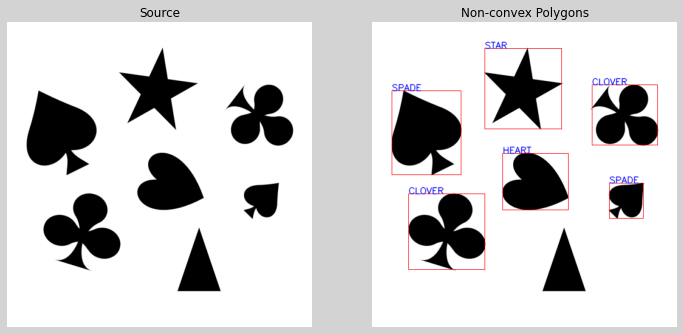

In [38]:
# pyplot으로 출력
plt.figure(figsize=(12, 6), facecolor="lightgray")

plt.subplot(121, title="Source").axis("off")
plt.imshow(source[:, :, ::-1])

plt.subplot(122, title="Non-convex Polygons").axis("off")
plt.imshow(destination[:, :, ::-1])

plt.show()

In [125]:
# OpenCV 가상 윈도우로 출력
cv2.imshow("Source", source)
cv2.imshow("Non-convex Polygons", destination)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1